# The following code for PPO is based off of our homework.

In [10]:
# # https://github.com/yihaosun1124/OfflineRL-Kit?tab=readme-ov-file
# Model-free
# Conservative Q-Learning (CQL)
# TD3+BC
# Implicit Q-Learning (IQL)
# Ensemble-Diversified Actor Critic (EDAC)
# Mildly Conservative Q-Learning (MCQ)

# Model-based
# Model-based Offline Policy Optimization (MOPO)
# Conservative Offline Model-Based Policy Optimization (COMBO)
# Robust Adversarial Model-Based Offline Reinforcement Learning (RAMBO)
# Model-Bellman Inconsistancy Penalized Offline Reinforcement Learning (MOBILE)

import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
sns.set(style="darkgrid")

import sys
sys.path.append('../models/simulator_and_model/')
from env import simulator


In [11]:
def evaluate_policy(policy, env, seed=42):
    env_test = env
    state, _ = env_test.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        dist = policy(state)
        next_state, reward, done, _, _ = env_test.step(dist.sample().item())
        state = next_state
        total_reward += reward
    return total_reward

In [12]:
# TODO: Implement the PolicyNetwork class

class PolicyNetwork(nn.Module):

  """
    Implement the Policy Network.

    Your task is to complete the initialization of the Policy Network, which maps states to action probabilities.

    The network should consist of three fully connected layers:

    1. An input layer that takes in state_dim and outputs 128 neurons.
    2. A hidden layer with 128 neurons.
    3. A final output layer that maps to action_dim, producing logits for each possible action.
    4. The activation function for the hidden layers should be ReLU (torch.relu).
    5. Implement the forward pass to return a Categorical distribution given state inputs.

    Hint: The constructor takes 'state_dim' and 'action_dim' as arguments, representing the dimensions
    of the state space and action space, respectively.
  """
  def __init__(self, state_dim, action_dim):
      super(PolicyNetwork, self).__init__()
      ##### Code implementation here #####
      self.fc1 = nn.Linear(state_dim, 128)
      self.fc2 = nn.Linear(128, 128)
      self.fc3 = nn.Linear(128, action_dim)

  def forward(self, x):
      ##### Code implementation here #####
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      logits = self.fc3(x)
      return torch.distributions.Categorical(logits=logits)
      

# TODO: Implement the ValueNetwork class
class ValueNetwork(nn.Module):
  """
    Implement the Value Network.

    Your task is to complete the initialization of the **Value Network**, which maps states to their estimated values.

    Network Architecture:
    - The network consists of **three fully connected layers**:
    1. An **input layer** that takes `state_dim` and outputs **128 neurons**.
    2. A **hidden layer** with **128 neurons**.
    3. A **final output layer** that produces a **single scalar value** representing the state's estimated value.
    4. Activation function for the hidden layers should be ReLU (torch.relu).


    Hint: The constructor takes 'state_dim' as an argument, representing the dimension of the state space.
  """
  def __init__(self, state_dim):
      super(ValueNetwork, self).__init__()
      ##### Code implementation here #####
      self.fc1 = nn.Linear(state_dim, 128)
      self.fc2 = nn.Linear(128, 128)
      self.fc3 = nn.Linear(128, 1)

  def forward(self, x):
      ##### Code implementation here #####
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = self.fc3(x)
      return x


In [13]:
# TODO: Implement the advantage function calculation

"""
Introduction: The function `compute_advantages` calculates **returns** using the **Generalized Advantage Estimation (GAE)** method.
GAE helps reduce variance while maintaining bias efficiency in reinforcement learning algorithms like PPO.

This function follows a **backward recursion** process:
1. The function receives `rewards`, `masks`, and `values`, which are **lists** representing a **trajectory** (a sequence of states and rewards).
2. The **masks** are used to handle terminal states (they are 0 if the episode ends and 1 otherwise).
3. It calculates **delta**, which is the temporal difference (TD) error.
4. The function accumulates **advantages** using the **recursive formula** for GAE.
5. Finally, it stores the **returns** (advantage + value function) for each step.

# Important Notes:
- As the recursion computation may be a bit tricky, you can adopt a simplr **for-loop** calculation if you desire.
- The function is named `compute_advantages`, but it actually calculates **returns** (advantage + value).
- The use of **masks** ensures that advantage propagation stops at the end of an episode.

As a reference for your understand, here is how **REINFORCE** computes returns in a recursion way:

  ```python
  def compute_returns(rewards, gamma=0.99):
      returns = []
      G = 0
      for reward in reversed(rewards):
          G = reward + gamma * G
          returns.insert(0, G)
      return returns
  ```
"""

def compute_advantages(next_value, rewards, masks, values, gamma=0.99, lambda_gae=0.95):
    values = values + [next_value]  # Append bootstrap value for last state
    advantages = 0
    returns = []

    for step in reversed(range(len(rewards))):  # Iterate in reverse (backward pass)
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]

        ##### Code implementation here #####
        advantages = delta + (gamma * lambda_gae) * masks[step] * advantages

        returns.insert(0, advantages + values[step])

    return returns

In [14]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    mini_batches = []

    for _ in range(batch_size // mini_batch_size):
        rand_ids = torch.randint(0, batch_size, (mini_batch_size,))
        mini_batch = states[rand_ids], actions[rand_ids], log_probs[rand_ids], returns[rand_ids], advantage[rand_ids]
        mini_batches.append(mini_batch)

    return mini_batches

In [15]:
def ppo_update(policy_net, value_net, optimizer, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    """
    Implement the PPO update algorithm.

    This function should perform the optimization of the policy and value networks using the Proximal Policy Optimization (PPO) algorithm.
    You'll need to compute the ratio of new and old policy probabilities, apply the clipping technique, and calculate the losses for both the actor (policy network) and critic (value network).

    Instructions:
    1. Iterate over the number of PPO epochs, which is the number of optimizer.step() with the current collected data.
    2. In each epoch, iterate over the mini-batches of experiences.
    3. Calculate the new log probabilities of the actions taken, using the policy network.
    4. Compute the ratio of new to old probabilities.
    5. Apply the PPO clipping technique to the computed ratios.
    6. Calculate the actor (policy) and critic (value) losses. You need to check the consistency for variable shapes before calculating the losses.
      6.1 Compute the actor loss:
        - The **surrogate objective** function is:
          \[
          L^{\text{clip}} = -\min(\text{ratio} \cdot \text{advantage}, \text{clipped_ratio} \cdot \text{advantage})
          \]
        - - The final **actor loss** is the mean of this objective.

      6.2 Compute the critic loss:
        - The value network should minimize the difference between predicted and actual returns:
          \[
          L^{\text{critic}} = (\text{return} - \text{value})^2
          \]
        - The final **critic loss** is the mean of this objective.

    7. Combine the losses and perform a backpropagation step.

    Hints:
    - Use `policy_net(state)` to get the distribution over actions for the given states.
    - The `dist.log_prob(action)` method calculates the log probabilities of the taken actions according to the current policy.
    - The ratio is computed as the exponential of the difference between new and old log probabilities (`(new_log_probs - old_log_probs).exp()`).
    - Use `torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param)` to clip the ratio between `[1-clip_param, 1+clip_param]`.
    - The actor loss is the negative minimum of the clipped and unclipped objective, averaged over all experiences in the mini-batch.
    - The critic loss is the mean squared error between the returns and the value estimates from the value network.
    - Remember to zero the gradients of the optimizer before the backpropagation step with `optimizer.zero_grad()`.
    - After computing the loss and performing backpropagation with `loss.backward()`, take an optimization step with `optimizer.step()`.
    """
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist = policy_net(state)
            new_log_probs = dist.log_prob(action)

            ##### Code implementation here #####
            # 4. Compute the ratio of new to old probabilities.
            ratio = (new_log_probs - old_log_probs).exp()
            
            # 5. Apply the PPO clipping technique to the computed ratios.
            clipped_ratio = torch.clamp(ratio, 
                                        1.0 - clip_param, 
                                        1.0 + clip_param)
            
            # 6.1 Compute the actor loss
            assert ratio.shape == clipped_ratio.shape
            
            advantage = torch.squeeze(advantage)
            
            assert ratio.shape == advantage.shape
            assert (ratio * advantage).shape == (clipped_ratio * advantage).shape
            
            actor_loss = -torch.minimum(ratio * advantage,
                                        clipped_ratio * advantage)
            actor_loss = torch.mean(actor_loss)
            
            # 6.2 Compute the critic loss
            value = value_net(state)
            assert value.shape == return_.shape
            
            critic_loss = (return_ - value) ** 2
            critic_loss = torch.mean(critic_loss)
            
            ##### Code implementation End #####

            loss = 0.5 * critic_loss + actor_loss  # You can freely adjust the weight of the critic loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [61]:
def train(env_input, num_steps=1000, mini_batch_size=8, ppo_epochs=4, threshold=400):
    env = env_input
    state_dim = env.observation_space.shape[0]
    action_dim = 4

    policy_net = PolicyNetwork(state_dim, action_dim)
    value_net = ValueNetwork(state_dim)
    optimizer = optim.Adam(list(policy_net.parameters()) + list(value_net.parameters()), lr=3e-3)

    state, _ = env.reset()
    early_stop = False
    reward_list = []

    for step in range(num_steps):
        log_probs = []
        values = []
        states = []
        actions = []
        rewards = []
        masks = []

        # Collect samples under the current policy
        for _ in range(2048):
            state = torch.tensor(np.array(state), dtype=torch.float32)  # Ensure correct tensor conversion
            dist, value = policy_net(state), value_net(state)

            action = dist.sample()
            next_state, reward, done, _, _ = env.step(int(action.item()))  # Ensure action is an int
            log_prob = dist.log_prob(action)

            log_probs.append(log_prob.unsqueeze(0))
            values.append(value.unsqueeze(0))
            rewards.append(torch.tensor([reward], dtype=torch.float32))
            masks.append(torch.tensor([1 - done], dtype=torch.float32))
            states.append(state.unsqueeze(0))
            actions.append(action.unsqueeze(0))  # Fix for actions


            state = next_state
            if done:
                state, _ = env.reset()  # Ensure proper Gym reset handling

        next_state = torch.tensor(np.array(next_state), dtype=torch.float32).unsqueeze(0)  # Ensure proper conversion
        next_value = value_net(next_state)
        returns = compute_advantages(next_value, rewards, masks, values)

        returns = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs).detach()
        values = torch.cat(values).detach()
        states = torch.cat(states)
        actions = torch.cat(actions)
        advantage = returns - values

        # torch.Size([2048, 7]) torch.Size([2048]) torch.Size([2048]) torch.Size([1, 7]) torch.Size([1, 1]) torch.Size([2048, 1]) torch.Size([2048, 1])
        # print(states.shape,actions.shape,log_probs.shape,next_state.shape, next_value.shape,returns.shape,advantage.shape)

        # Run PPO update for policy and value networks
        ppo_update(policy_net, value_net, optimizer, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)

        if step % 1 == 0:
            l = [evaluate_policy(policy_net, env) for _ in range(10)]
            test_reward = np.mean(l)
            if step % 10 == 0:
                print(f'Step: {step}\tReward: {test_reward}')
            # reward_list.append(test_reward)
            reward_list += [test_reward]
            if test_reward > threshold:
                print("Solved!")
                early_stop = True
                break
    return early_stop, reward_list, policy_net, value_net

Step: 0	Reward: 91.9
Step: 10	Reward: 106.1
Step: 20	Reward: 122.2
Step: 30	Reward: 106.8
Step: 40	Reward: 122.9
Step: 50	Reward: 118.6
Step: 60	Reward: 120.2
Step: 70	Reward: 104.4
Step: 80	Reward: 128.9
Step: 90	Reward: 129.9
Step: 100	Reward: 125.7
Step: 110	Reward: 141.2
Step: 120	Reward: 129.9
Step: 130	Reward: 125.0
Step: 140	Reward: 130.8
Step: 150	Reward: 131.5
Step: 160	Reward: 119.7
Step: 170	Reward: 146.5
Step: 180	Reward: 132.5
Step: 190	Reward: 140.7
Step: 200	Reward: 136.7
Step: 210	Reward: 161.3
Step: 220	Reward: 127.3
Step: 230	Reward: 128.9
Step: 240	Reward: 124.5
Step: 250	Reward: 131.8
Step: 260	Reward: 138.7
Step: 270	Reward: 122.5
Step: 280	Reward: 128.5
Step: 290	Reward: 131.8
Step: 300	Reward: 119.5
Step: 310	Reward: 124.2
Step: 320	Reward: 114.2
Step: 330	Reward: 101.4
Step: 340	Reward: 133.0
Step: 350	Reward: 134.2
Step: 360	Reward: 109.3
Step: 370	Reward: 129.7
Step: 380	Reward: 134.2
Step: 390	Reward: 120.1
Step: 400	Reward: 125.2
Step: 410	Reward: 120.0
Step

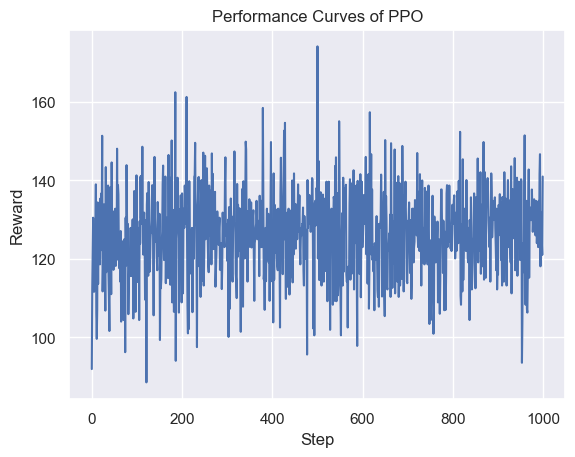

In [62]:
threshold = 400

def reward(self, penalty, action):
    extra = 0
    if self.done == 1 and self.correct_solution == 0:
        extra = -8
    if action == 2:
        penalty = -5
    return self.prob_count * 13 + self.listen_to_feedback_count * 10 + extra + penalty + self.convo_turn + self.progress_delta

env = simulator(reward)

early_stop, reward_list, policy_net, value_net = train(env, num_steps=1000, mini_batch_size=32, ppo_epochs=32, threshold=threshold)

# sns.lineplot(x=np.arange(len(reward_list)), y=reward_list, color='salmon', marker='o', linestyle='-')
plt.plot(reward_list)

# Optional: Adding titles and labels
plt.title('Performance Curves of PPO')
plt.xlabel('Step')
plt.ylabel('Reward')
# plt.legend()

# Show the plot
plt.show()

In [23]:
policy_net

PolicyNetwork(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [84]:
# policy evaluation with Monte Carlo
def eval_policy(policy, eval_env, eval_episodes=10):
        avg_reward = 0.0
        for _ in range(eval_episodes):
            state, _ = eval_env.reset()
            done = False
            step = 0
            while not done:
                state = torch.tensor(state, dtype=torch.float32)
                action = policy.select_action(state)
                state, reward, terminated, _, _ = eval_env.step(action)
                avg_reward += reward
                step += 1
                done = terminated
        avg_reward /= eval_episodes

        # print("---------------------------------------")
        # print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
        # print("---------------------------------------")
        return avg_reward

class PolicyWrapper:
    def __init__(self, network):
        self.model = network
    def select_action(self, state):
        dist = self.model(state)
        action = dist.sample()
        return int(action.item())


In [85]:
policy_net(torch.tensor([2., 0., 0., 0., 0., 0., 0.])).sample()

tensor(1)

In [88]:
ppo_returns = [eval_policy(PolicyWrapper(policy_net), env, eval_episodes=10) for i in range(1000)]


In [90]:
import pickle
file = open('../ppo_returns.pkl', 'wb')
pickle.dump(ppo_returns, file)
file.close()

In [86]:
def reward(self, penalty, action):
    extra = 0
    if self.done == 1 and self.correct_solution == 0:
        extra = -8
    if action == 2:
        penalty = -5
    return self.prob_count * 13 + self.listen_to_feedback_count * 10 + extra + penalty + self.convo_turn + self.progress_delta

env = simulator(reward)

In [87]:
eval_policy(PolicyWrapper(policy_net), env, eval_episodes=10)

127.7

In [21]:
class uniform_dist:
    def sample(self):
        return torch.randint(0, 4, (1,))
class RandomPolicy:
  def forward(self, x):
      ##### Code implementation here #####
      return uniform_dist()
      

In [9]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt


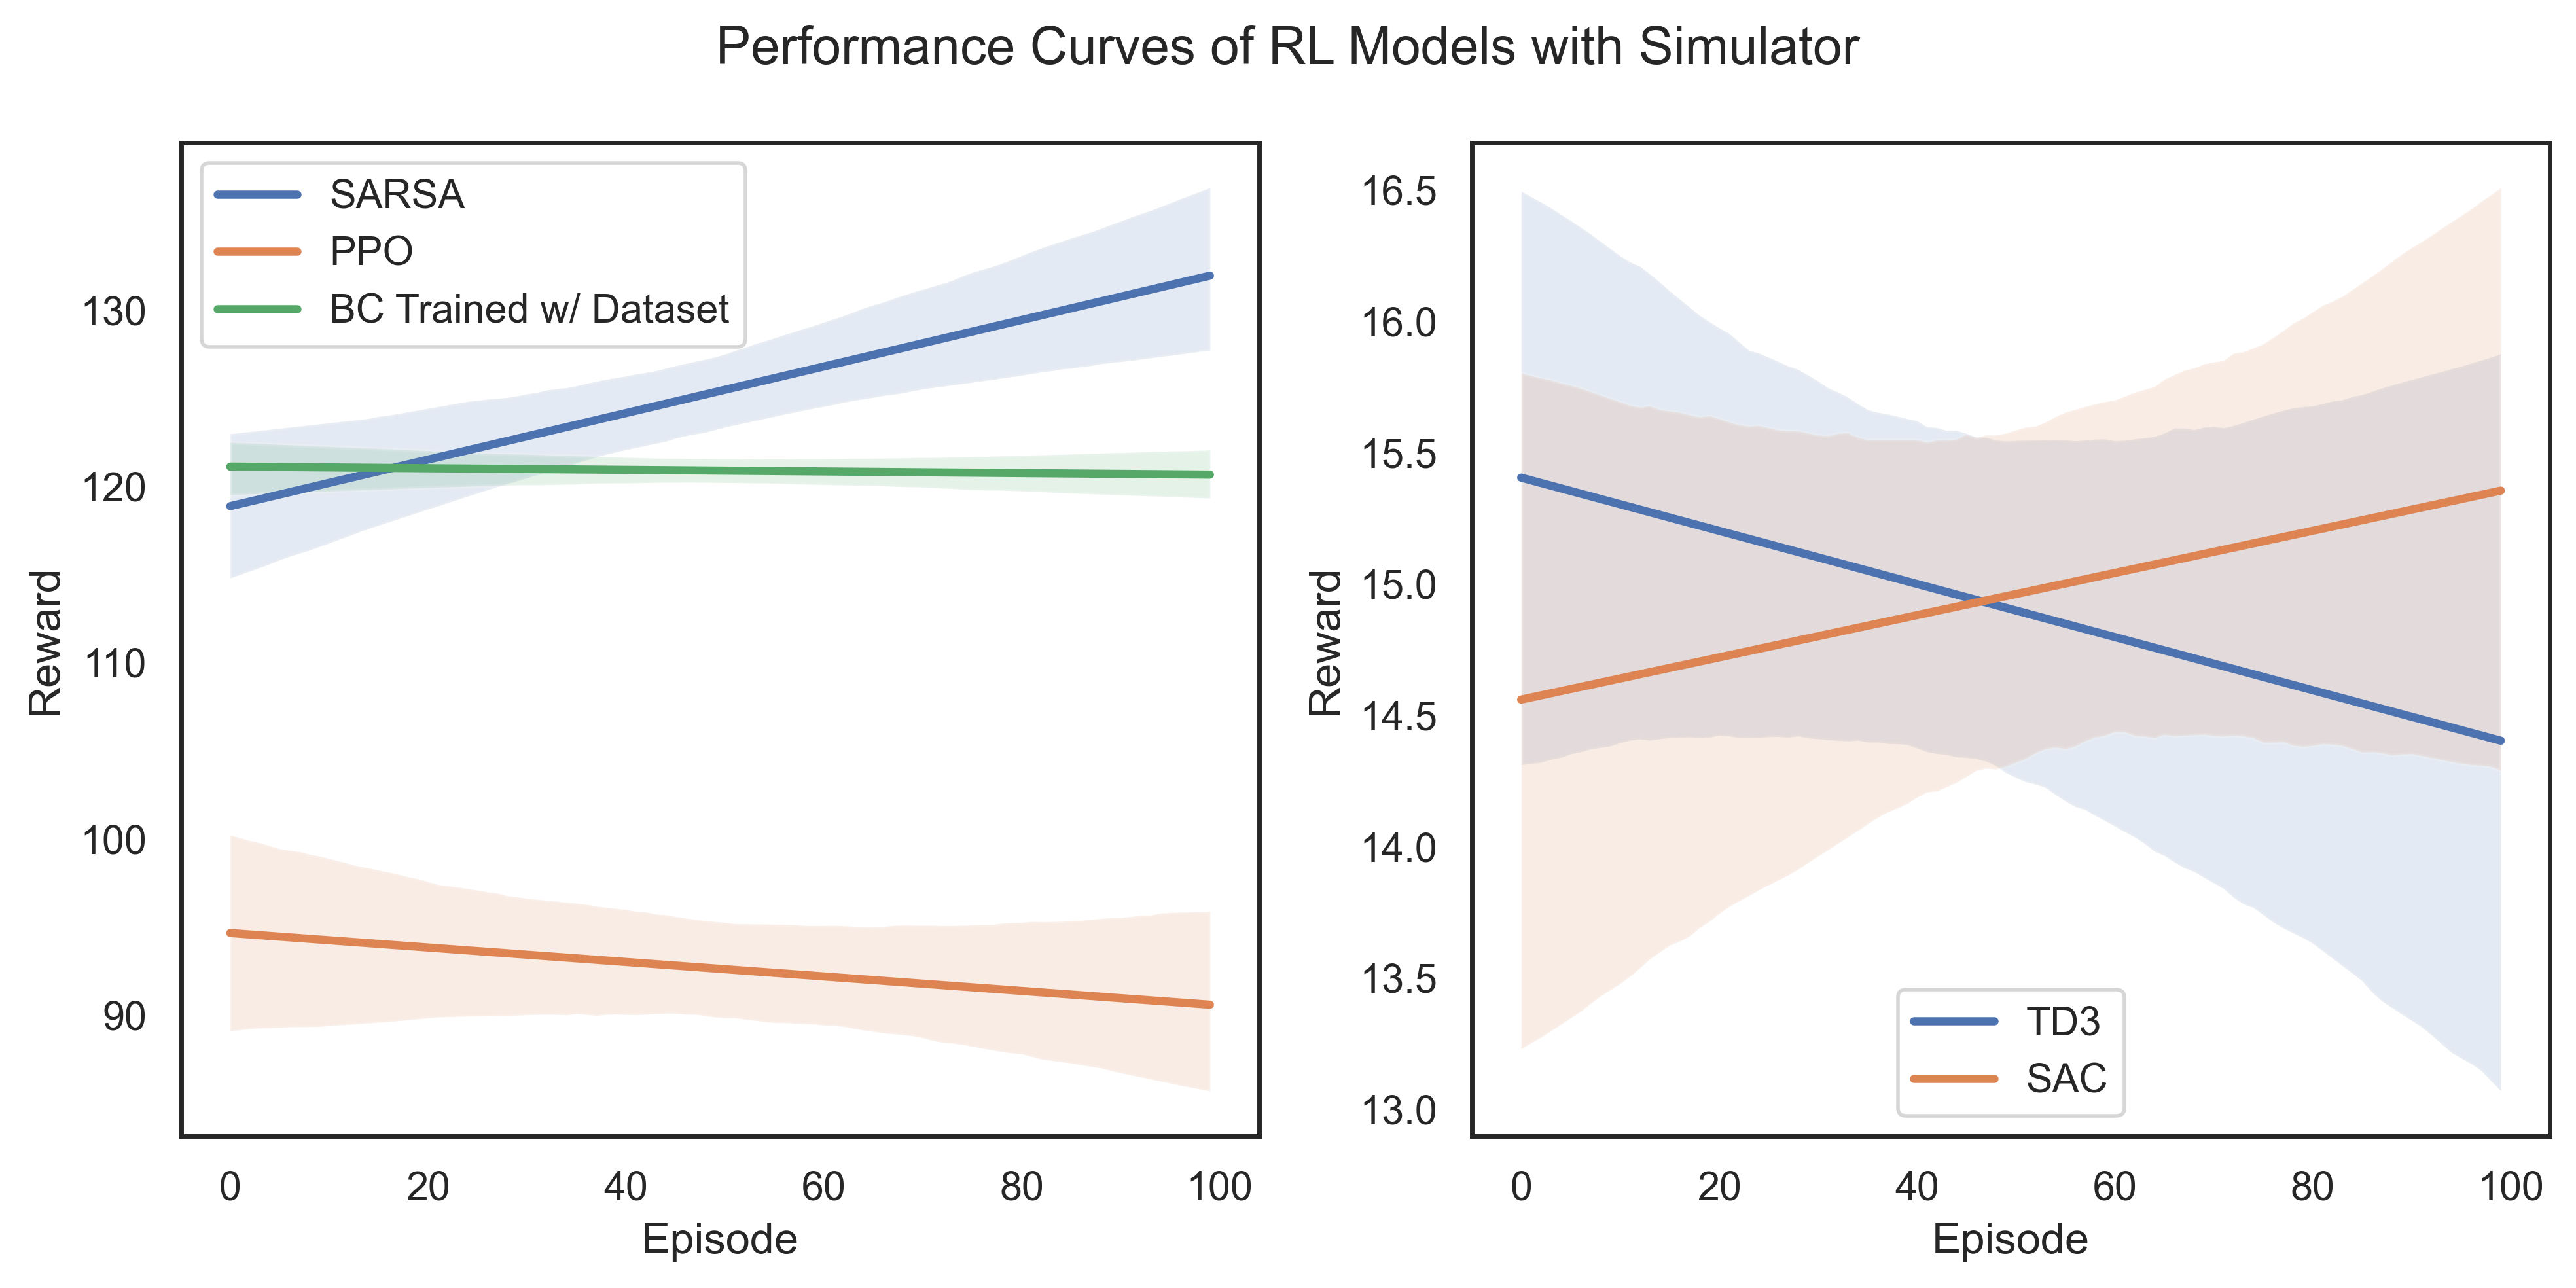

In [70]:
import numpy as np
import seaborn as sns
sns.set(style="white")

fig, axs = plt.subplots(1,2,figsize=(10, 5), dpi=400)

ax = axs[0]
sns.regplot(x=np.arange(100), y=sarsa_rewards_average, ax=ax, label='SARSA',scatter=False)
sns.regplot(x=np.arange(100), y=reward_list, ax=ax, label='PPO',scatter=False)
sns.regplot(x=np.arange(100), y=BC_rewards_average, ax=ax, label='BC Trained w/ Dataset',scatter_kws={'alpha':0.6},scatter=False)
ax.legend()
ax.set(xlabel='Episode', ylabel='Reward')

ax =axs[1]
sns.regplot(x=np.arange(100), y=TD3_rewards_average, ax=ax, label='TD3',scatter=False)
sns.regplot(x=np.arange(100), y=SAC_rewards_average, ax=ax, label='SAC',scatter=False)
ax.set(xlabel='Episode', ylabel='Reward')
ax.legend()


plt.suptitle("Performance Curves of RL Models with Simulator")

fig.tight_layout()

plt.show()

In [19]:
%store -r sarsa_rewards_average

In [28]:
ls ../

BC_5000epochs_6layers_1024neurons.pt  imitative learning_YD.ipynb
Expected_SARSA.ipynb                  sarsa_rewards_average.pkl
__pycache__/                          simulator_and_related_models/
data_generator.ipynb


In [62]:
import pickle
dbfile = open('../SAC_rewards_average.pkl', 'rb')
SAC_rewards_average = pickle.load( dbfile)
dbfile.close()

In [30]:
sarsa_rewards_average

[np.float64(107.0),
 np.float64(105.0),
 np.float64(126.6),
 np.float64(110.3),
 np.float64(91.4),
 np.float64(124.6),
 np.float64(123.1),
 np.float64(124.6),
 np.float64(120.2),
 np.float64(104.4),
 np.float64(118.9),
 np.float64(113.9),
 np.float64(119.3),
 np.float64(133.5),
 np.float64(118.9),
 np.float64(119.6),
 np.float64(119.2),
 np.float64(123.9),
 np.float64(133.4),
 np.float64(104.9),
 np.float64(123.6),
 np.float64(136.7),
 np.float64(114.7),
 np.float64(143.8),
 np.float64(120.6),
 np.float64(115.2),
 np.float64(111.9),
 np.float64(116.1),
 np.float64(105.4),
 np.float64(131.8),
 np.float64(121.6),
 np.float64(134.4),
 np.float64(133.8),
 np.float64(113.8),
 np.float64(109.4),
 np.float64(118.1),
 np.float64(128.5),
 np.float64(137.1),
 np.float64(116.7),
 np.float64(133.8),
 np.float64(123.0),
 np.float64(133.8),
 np.float64(130.8),
 np.float64(123.4),
 np.float64(133.8),
 np.float64(130.9),
 np.float64(133.8),
 np.float64(132.2),
 np.float64(128.9),
 np.float64(115.2),
 

In [ ]:
# Step: 0	Reward: 67.4
# Step: 10	Reward: 70.1
# Step: 20	Reward: 79.1
# Step: 30	Reward: 66.6
# Step: 40	Reward: 83.0
# Step: 50	Reward: 63.4
# Step: 60	Reward: 103.1
# Step: 70	Reward: 75.9
# Step: 80	Reward: 99.0
# Step: 90	Reward: 99.6

/var/folders/k2/dswywzf54kj4kvblpc5ns30w0000gn/T/ipykernel_33997/448239255.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


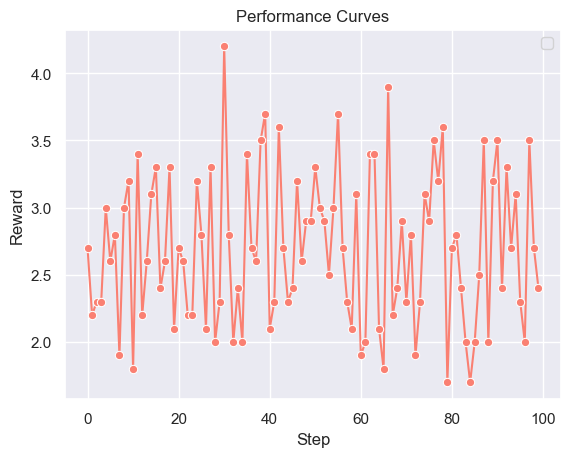

In [10]:
# if not early_stop:
#     print("Not solved in %d steps"%len(reward_list))

# Plot using Seaborn
sns.lineplot(x=np.arange(len(reward_list)), y=reward_list, color='salmon', marker='o', linestyle='-')

# Optional: Adding titles and labels
plt.title('Performance Curves')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()

# Show the plot
plt.show()